In [35]:
import os
import math
import argparse
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [36]:
parser = argparse.ArgumentParser(description='Plothole Segmentation')
parser.add_argument("--path", type=str, default=os.path.join(os.getcwd(), "data"), help="Path to the data directory")
args = parser.parse_args(args=[])

In [37]:
path = args.path
if not os.path.exists(path):
    raise ValueError(f"Path {path} does not exist")

In [38]:
imagePath = os.path.join(path, "images")

trainPath = os.path.join(imagePath, "train")
validPath = os.path.join(imagePath, "valid")

trainImagePath = os.path.join(trainPath, "images")
trainLabelsPath = os.path.join(trainPath, "labels")

In [39]:
trainImage = sorted(os.listdir(trainImagePath))
trainLabels = sorted(os.listdir(trainLabelsPath))

if len(trainImage) != len(trainLabels):
    raise ValueError(f"Number of images and labels do not match")

for i in range(len(trainImage)):
    trainImage[i] = trainImage[i][:-4]
    trainLabels[i] = trainLabels[i][:-4]

imageDF = pd.DataFrame({"image": trainImage})
labelDF = pd.DataFrame({"label": trainLabels})

trainDF = pd.merge(imageDF, labelDF, left_on="image", right_on="label", how="inner")

---

## Show segmentation mask (points) 

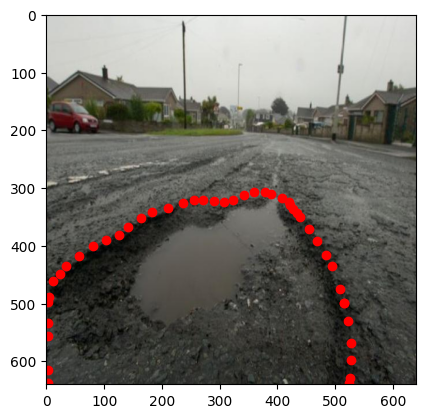

In [43]:
trainDF = trainDF.sample(frac=1).reset_index(drop=True)
for _, row in trainDF.iterrows():
    image = cv.imread(os.path.join(trainImagePath, row["image"] + ".jpg"))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    implot = plt.imshow(image)

    xlim = math.ceil(implot.axes.get_xlim()[1])
    ylim = math.ceil(implot.axes.get_ylim()[0])

    with open(os.path.join(trainLabelsPath, row["label"] + ".txt"), "r") as f:
        lines = f.readlines()
        for line in lines:
            line = [float(elem) for elem in line.strip().split(" ")[1:]]
            xs, ys = [], []
            for i in range(len(line)):
                xs.append(line[i] * xlim) if i % 2 == 0 else ys.append(line[i] * ylim)
            plt.scatter(xs, ys, color="red")
    plt.show()
    break

---

## Get bounding box from segmentation mask (points)

In [41]:
def seg_to_bbox(seg_info):
    class_id, *points = seg_info.split()
    points = [float(p) for p in points]
    x_min, y_min, x_max, y_max = min(points[0::2]), min(points[1::2]), max(points[0::2]), max(points[1::2])
    bbox_info = f"{class_id} {x_min} {y_min} {x_max} {y_max}"
    return bbox_info

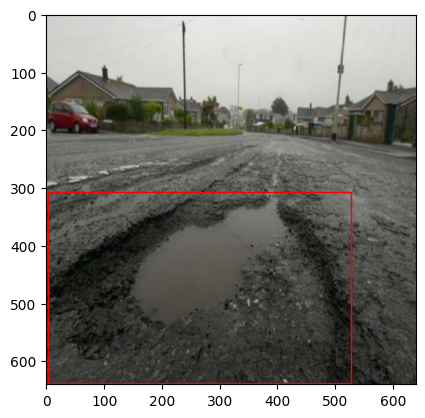

In [44]:
for _, row in trainDF.iterrows():
    image = cv.imread(os.path.join(trainImagePath, row["image"] + ".jpg"))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    implot = plt.imshow(image)

    xlim = math.ceil(implot.axes.get_xlim()[1])
    ylim = math.ceil(implot.axes.get_ylim()[0])

    with open(os.path.join(trainLabelsPath, row["label"] + ".txt"), "r") as f:
        lines = f.readlines()
        for line in lines:
            line = seg_to_bbox(line)[1:]
            line = [float(elem) for elem in line.strip().split(" ")]
            xs, ys = [], []
            for i in range(len(line)):
                xs.append(line[i] * xlim) if i % 2 == 0 else ys.append(line[i] * ylim)
            rect = Rectangle((xs[0], ys[0]), xs[1] - xs[0], ys[1] - ys[0], fill=False, color="red")
            plt.gca().add_patch(rect)
    plt.show()
    break